In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
#wandb_id = '3cyfilm7'
#models_dir = './wandb_models'
# wandb.init(project="asmr-impact", resume=resume, id=wandb_id)
# wandb_id = wandb.run.id
#save_dir = os.path.join('./wandb', wandb_id)
#conf = wandb.config
#print(wandb_id)

3cyfilm7


In [2]:
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 1 #0.5
offset_secs = 1.17

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-0.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav


In [3]:
model = ddsp.training.models.get_model()

Z time steps: 252


In [4]:
model.restore(save_dir)

INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


In [6]:
# Loading and processing audio
MAX_WAV_VALUE = 32768.0
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-173-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
#audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-198-of-365" # Ceramic plate example
audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-72-of-365' # Glassbowl example
#audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio.shape)

# waveglow style
print("decoded audio before: ", decoded_audio)
# decoded_audio = decoded_audio / MAX_WAV_VALUE
print("decoded audio after: ", decoded_audio)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
IPython.display.Audio(data=decoded_audio, rate=int(audio_sample_rate))

audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (440320, 1)
decoded audio before:  tf.Tensor(
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00015259]
 [0.00015259]
 [0.00018311]], shape=(440320, 1), dtype=float32)
decoded audio after:  tf.Tensor(
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.00015259]
 [0.00015259]
 [0.00018311]], shape=(440320, 1), dtype=float32)
(1, 44100)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 44100), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 44100)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[9.58617106e-02 7.01715946e-02 1.86996117e-01 ... 1.12778725e-04
   1.29621912e-04 2.66805291e-05]
  [8.56391639e-02 1.12216264e-01 3.86508435e-01 ... 2.06169672e-04
   1.43476092e-04 9.64142382e-05]
  [1.69967398e-01 3.42026174e-01 5.26982486e-01 ... 9.40174505e-05
   1.05920772e-04 1.70022249e-05]
  ...
  [4.58133966e-02 3.29136439e-02 9.43722576e-03 ... 1.24617858e-04
   4.22530647e-05 1.17719173e-06]
  [7.06391549e-03 6.77427184e-03 5.92622859e-03 ... 3.97348376e-05
   2.48282595e-05 1.04228966e-05]
  [2.76177616e-05 2.79296219e-05 2.88238953e-05 ... 1.46853847e-06
   1.43666148e-06 1.42586396e-06]]], shape=(1, 173, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.0000000e+00 5.6118201e-02 1.4053394e-02 ... 1.0173458e-01
   4.168527

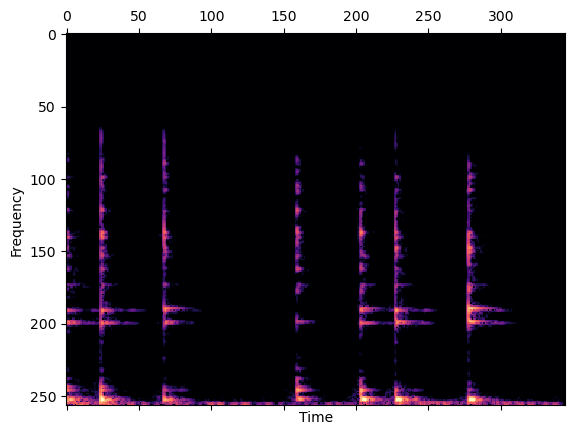

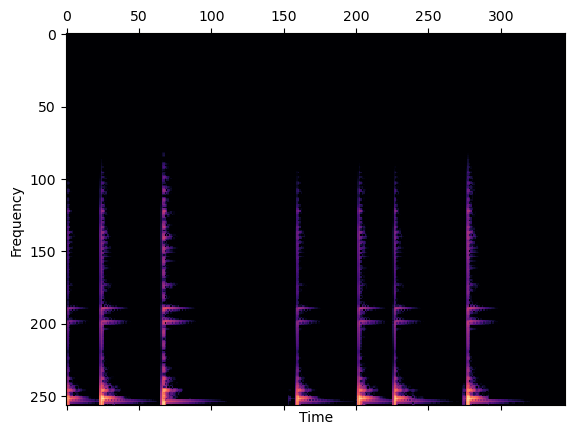

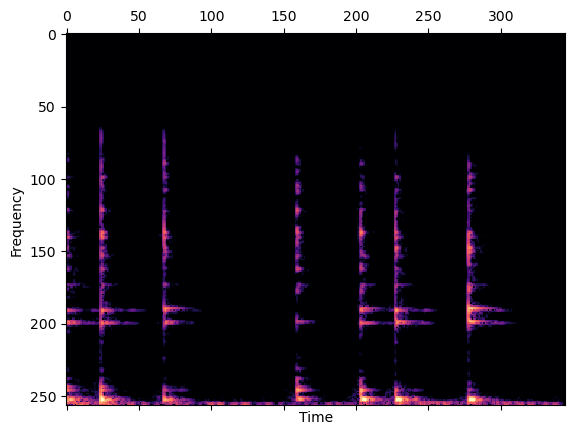

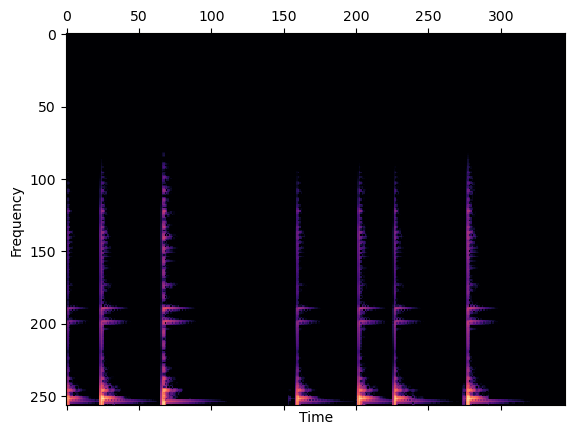

In [7]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [7]:
for k in prediction:
    print(k)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

inputs
audio
material_id
video_id
z
material_embedding
magnitudes
stdevs
taus
gains
frequencies
dampings
tau_multiplier
acceleration_scalar
reverb_gain
reverb_decay
noise_magnitudes
impact
modal_fir
convolve
filtered_noise
add1
acceleration_multiply
add2
reverb
resample
out
audio_synth
tf.Tensor([[0.01559967]], shape=(1, 1), dtype=float32)
tf.Tensor(
[[ 0.00234329 -0.0036285   0.02966794  0.02578888 -0.09611432  0.10113382
  -0.01739896 -0.07547379  0.18080805  0.00281618  0.09012411  0.02933635
  -0.00706805  0.04616449  0.25710884  0.1464489   0.47209966 -0.00558962
   0.0145811  -0.00495632 -0.02088506  0.05109269  0.01438165  0.01321384
  -0.04677949 -0.01578008 -0.0060592   0.07381374  0.02992893  0.03537934
   0.43692726 -0.01033593]], shape=(1, 32), dtype=float32)


In [8]:
print(prediction['impact']['signal'])

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 88200), dtype=float32)


In [2]:
# Try all of the above with mel spectrogram as input instead of audio
vocoder_type = "glass-bowl"
save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}'
example_secs = 1 # This determines how the time dims of output in seconds. Set to 10 for full orig audio
offset_secs = 1.17

latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

Latest operative config used:  /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/operative_config-1.gin
-4
4.0
/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-001-*.wav


In [3]:
model = ddsp.training.models.get_model()

Z time steps: 252


In [4]:
model.restore(save_dir)

INFO:absl:Loaded checkpoint /juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/glass-bowl/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


In [5]:
from IPython.display import display
import soundfile as sf
# Loading and processing audio
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365.wav'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-100-of-365'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_mel.npy')

# sf.write(os.path.join(save_dir, audio_title+'_original_audio.wav'),
#                        orig_audio[offset_samples:(offset_samples + test_samples)], 44100)

print("mel spectrogram vanilla: ", audio)
# regnet prediction/output
# audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy") # From regnet output

print("orig audio shape: ", orig_audio.shape)
print("mel spec shape: ", audio.shape)
audio_sample_rate = 44100
# Force it to 87 time dim to be 0.5 seconds
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# 1 second is 172 in mel spec time dimensions
audio = audio[:, int(offset_secs * 172):int(offset_secs*172 + example_secs*172)]
# if example_secs == 0.5:
#     audio = audio[:, :87]
# elif example_secs == 5:
#     audio = audio[:, 861:]
# elif example_secs == 1:
#     audio = audio[:, :172]
    
audio = np.transpose(audio)
tf_audio = tf.convert_to_tensor(audio)
decoded_mel_spec = tf.expand_dims(tf_audio, axis=0)

# For original audio
orig_audio = tf.convert_to_tensor(orig_audio)
#decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[:test_samples]), axis=0)
#decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio), axis=0)
print("decoded orig audio shape: ", decoded_orig_audio.shape)

# Save the shortened audio
# scipy.io.wavfile.write(os.path.join(save_dir, audio_title+'_original_audio.wav'), audio_sample_rate,
#                        tf.make_ndarray(tf.make_tensor_proto(orig_audio[offset_samples:(offset_samples + test_samples)])))
#synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)

# Compare to load from wav
compare_decoded_audio, compare_audio_sample_rate = tf.audio.decode_wav(compare_audio, desired_channels=1)
compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
#compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[:test_samples]), axis=0)
#compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio), axis=0)
print("compare decoded orig audio (from wav): ", compare_decoded_orig_audio.shape)

print(decoded_mel_spec.shape)
test_input_new = tf.data.Dataset.from_tensor_slices({'audio':decoded_mel_spec, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input_new)

print("decoded orig audio loaded with numpy")
print(decoded_orig_audio)
#plt.plot(decoded_orig_audio)
display(IPython.display.Audio(data=decoded_orig_audio, rate=int(audio_sample_rate)))

print("decoded orig audio loaded with tensorflow")
print(compare_decoded_orig_audio)
display(IPython.display.Audio(data=compare_decoded_orig_audio, rate=int(audio_sample_rate)))
#plt.show()

mel spectrogram vanilla:  [[-11.512925  -11.512925   -8.285768  ...  -3.525048   -4.7328687
   -4.6909904]
 [-11.512925  -11.512925   -8.09303   ...  -4.5592575  -5.677803
   -5.84312  ]
 [-11.512925  -11.512925   -7.88805   ...  -6.1050863  -6.1220856
   -7.4842157]
 ...
 [-11.512925  -11.512925  -11.512925  ...  -9.183427   -9.469207
  -11.142398 ]
 [-11.512925  -11.512925  -11.512925  ...  -9.485366   -9.960242
  -11.512925 ]
 [-11.512925  -11.512925  -11.512925  ...  -9.99114   -10.4671135
  -11.512925 ]]
orig audio shape:  (441000,)
mel spec shape:  (80, 1720)
decoded orig audio shape:  (1, 44100)
compare decoded orig audio (from wav):  (1, 44100)
(1, 172, 80)
input to the model:  <BatchDataset shapes: {audio: (None, 172, 80), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>
decoded orig audio loaded with numpy
tf.Tensor([[ 14.  16.  16. ...  17.  14. -35.]], shape=(1, 44100), dtype=float32)


decoded orig audio loaded with tensorflow
tf.Tensor(
[[ 0.00030518  0.00033569  0.00039673 ... -0.00494385 -0.00708008
  -0.00311279]], shape=(1, 44100), dtype=float32)


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 172, 80)
passing in the log mel spectrogram as is...
Mel spec MFCC logmel shape:  (1, 172, 80)
log mel values:  tf.Tensor(
[[[ -5.718073   -7.1247444  -7.257015  ... -11.512925  -11.512925
   -11.512925 ]
  [ -5.5580697  -6.7165427  -7.385764  ... -11.512925  -11.512925
   -11.512925 ]
  [ -5.814795   -7.8523927  -7.073192  ... -11.512925  -11.512925
   -11.512925 ]
  ...
  [ -3.441331   -4.5709724  -5.667815  ...  -8.08199    -8.987253
    -9.990481 ]
  [ -4.2160544  -5.3923445  -7.500162  ...  -7.7475142  -9.624763
   -10.372516 ]
  [ -5.457428   -6.639557   -7.138772  ...  -7.35868    -9.687081
   -10.855912 ]]], shape=(1, 172, 80), dtype=float32)
mel spec mfcc shape:  (1, 172, 80)
Input to processor group:  dict_keys(['audio', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_multiplier',

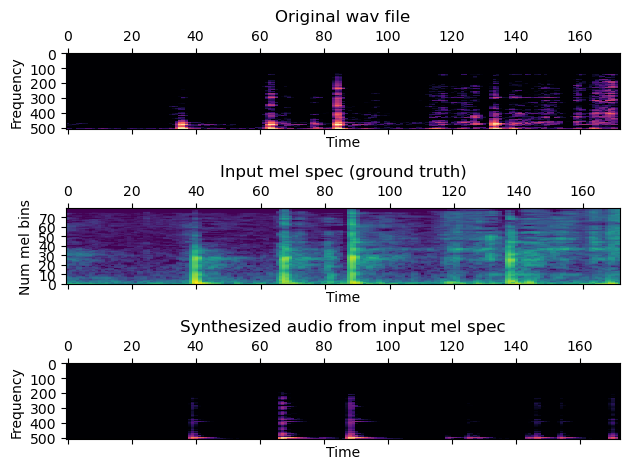

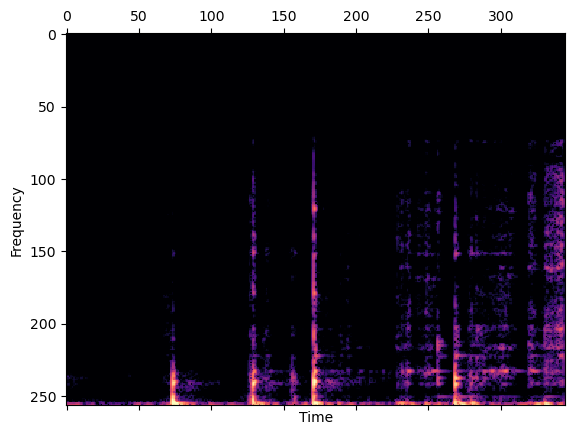

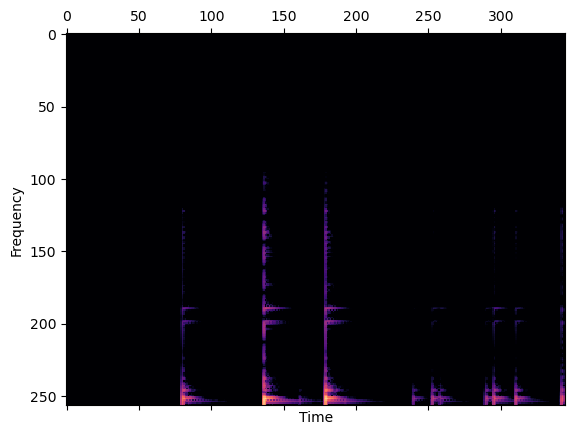

In [6]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
#import librosa
#print(librosa.__version__)
MAX_WAV_VALUE = 32768.0
prediction = model(next(iter(test_input_new)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)

# Saving the audio
# synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)
# with open(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'), 'wb') as f:
#     f.write(synth_wav)
# proto_tensor = tf.make_tensor_proto(a)
# np_array_synth = tf.make_ndarray(synth_wav)
# scipy.io.wavfile.write(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'),
#                         audio_sample_rate, synth_wav)
# sf.write(os.path.join(save_dir, audio_title+'_gt_mel_spec_synth.wav'),
#                        tf.make_ndarray(prediction['audio_synth'][:1, :]), int(audio_sample_rate))
# scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))

# plt.figure(figsize=(13, 10))
#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][0,:,:], size=512)

# ddsp.colab.colab_utils.specplot_mel_spec(prediction['audio'][0,:,:], size=512)
fig, axs = plt.subplots(3)
title1 = 'Original wav file'
axs[0].set_title(title1)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024, axs=axs[0]) #orig wav file

axs[1].matshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
axs[1].set_title("Input mel spec (ground truth)")
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Num mel bins')

title2 = 'Synthesized audio from input mel spec'
axs[2].set_title(title2)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024, axs=axs[2]) # synthesized audio pred
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

# ddsp.colab.colab_utils.specplot(prediction['audio'][0,:, :train_sample_rate*2], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [7]:
for k in prediction:
    print(k)
print(prediction['reverb_decay'])
print(prediction['reverb_gain'])

inputs
audio
material_id
video_id
z
material_embedding
magnitudes
stdevs
taus
gains
frequencies
dampings
tau_multiplier
acceleration_scalar
reverb_gain
reverb_decay
noise_magnitudes
impact
modal_fir
convolve
filtered_noise
add1
acceleration_multiply
add2
reverb
resample
out
audio_synth
tf.Tensor([[0.01559967]], shape=(1, 1), dtype=float32)
tf.Tensor(
[[ 0.00234329 -0.0036285   0.02966794  0.02578888 -0.09611432  0.10113382
  -0.01739896 -0.07547379  0.18080805  0.00281618  0.09012411  0.02933635
  -0.00706805  0.04616449  0.25710884  0.1464489   0.47209966 -0.00558962
   0.0145811  -0.00495632 -0.02088506  0.05109269  0.01438165  0.01321384
  -0.04677949 -0.01578008 -0.0060592   0.07381374  0.02992893  0.03537934
   0.43692726 -0.01033593]], shape=(1, 32), dtype=float32)


In [8]:
print(prediction['impact']['signal'])

tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 88200), dtype=float32)


In [9]:
# Compare against regnet's output mel spectrogram
print("Using Regnet's prediction log mel spectrogram")
from IPython.display import display
example_secs = 1 # This determines how the time dims of output in seconds. Set to 10 for full orig audio
offset_secs = 1.17
# Loading and processing audio
# audio = tf.io.read_file('/home/samuel/Development/asmr/synthetic/guitar_body2/valid/synthetic-guitar2-0010.wav')
# audio = tf.io.read_file('/data/datasets/asmr/tapping/materials/IlJYaR2D7GU-012-valid-0000.wav')
#audio = tf.io.read_file('/data/datasets/asmr/tapping/valid/sIgkTYTWPz8-004-0000.wav')

#audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365.wav'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365'
# audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-273-of-365'
audio_title = 'The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-1032-of-1165'
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_mel.npy')

# regnet prediction/output
audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy") # For regnet output

print("orig audio shape: ", orig_audio.shape)
print("mel spec shape: ", audio.shape)
audio_sample_rate = 44100
# Force it to 87 time dim to be 0.5 seconds
audio = audio[:, int(offset_secs * 172):int(offset_secs*172 + example_secs*172)]
#audio = audio[:, :87]
# audio = audio[:, :172]
audio = np.transpose(audio)
tf_audio = tf.convert_to_tensor(audio)
decoded_mel_spec = tf.expand_dims(tf_audio, axis=0)

# For original audio
orig_audio = tf.convert_to_tensor(orig_audio)
#decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[offset_samples:(offset_samples + test_samples)]), axis=0)
# decoded_orig_audio = tf.expand_dims(tf.squeeze(orig_audio[:test_samples]), axis=0)
print("decoded orig audio shape: ", decoded_orig_audio.shape)

# Compare to load from wav
compare_decoded_audio, compare_audio_sample_rate = tf.audio.decode_wav(compare_audio, desired_channels=1)
# compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[:test_samples]), axis=0)
compare_decoded_orig_audio = tf.expand_dims(tf.squeeze(compare_decoded_audio[offset_samples:(offset_samples + test_samples)]), axis=0)

# Add the processed mel spec to input
print(decoded_mel_spec.shape)
test_input_new = tf.data.Dataset.from_tensor_slices({'audio':decoded_mel_spec, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input_new)

print("decoded orig audio loaded with numpy")
print(decoded_orig_audio)
display(IPython.display.Audio(data=decoded_orig_audio, rate=int(audio_sample_rate)))

print("decoded orig audio loaded with tensorflow")
print(compare_decoded_orig_audio)
display(IPython.display.Audio(data=compare_decoded_orig_audio, rate=int(audio_sample_rate)))

Using Regnet's prediction log mel spectrogram
orig audio shape:  (441000,)
mel spec shape:  (80, 1720)
decoded orig audio shape:  (1, 44100)
(1, 172, 80)
input to the model:  <BatchDataset shapes: {audio: (None, 172, 80), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>
decoded orig audio loaded with numpy
tf.Tensor([[ 14.  16.  16. ...  17.  14. -35.]], shape=(1, 44100), dtype=float32)


decoded orig audio loaded with tensorflow
tf.Tensor(
[[ 0.00030518  0.00033569  0.00039673 ... -0.00494385 -0.00708008
  -0.00311279]], shape=(1, 44100), dtype=float32)


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 172, 80)
passing in the log mel spectrogram as is...
Mel spec MFCC logmel shape:  (1, 172, 80)
log mel values:  tf.Tensor(
[[[ -4.6108117  -4.546528   -4.5341315 ... -11.361057  -11.307845
   -11.317619 ]
  [ -4.749879   -4.9377627  -5.3815784 ... -11.200466  -11.068035
   -11.19234  ]
  [ -5.0424986  -5.5909925  -6.360691  ... -11.267506  -11.269601
   -11.229385 ]
  ...
  [ -5.614657   -6.237666   -6.809435  ... -11.490736  -11.49812
   -11.675611 ]
  [ -5.7513795  -6.294419   -6.8338203 ... -11.458768  -11.53133
   -11.668654 ]
  [ -5.519898   -5.971703   -6.4587865 ... -11.127449  -11.212626
   -11.439467 ]]], shape=(1, 172, 80), dtype=float32)
mel spec mfcc shape:  (1, 172, 80)
Input to processor group:  dict_keys(['audio', 'material_id', 'video_id', 'z', 'material_embedding', 'magnitudes', 'stdevs', 'taus', 'gains', 'frequencies', 'dampings', 'tau_multiplier', '

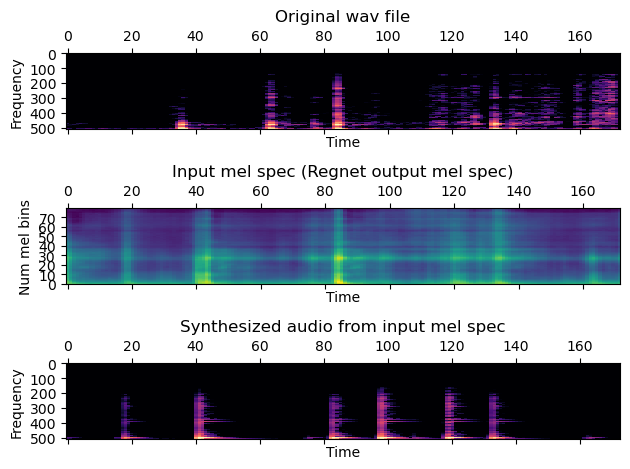

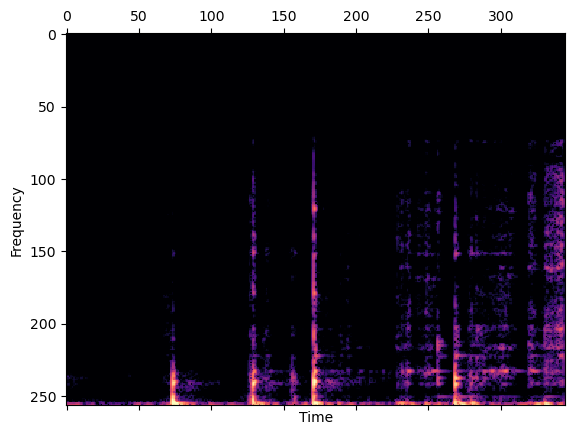

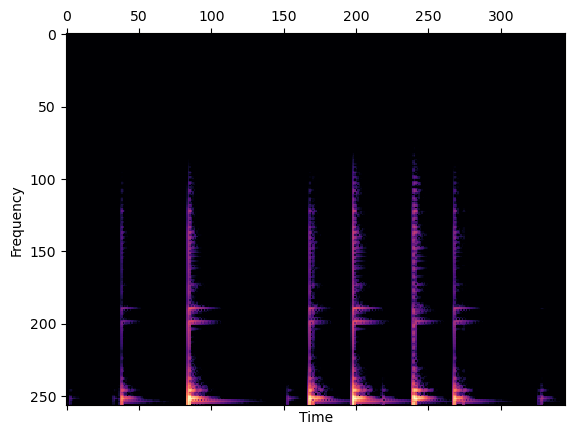

In [10]:
# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
prediction = model(next(iter(test_input_new)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)

# Saving the audio
# synth_wav = tf.audio.encode_wav(prediction['audio_synth'][:1, :], sample_rate=audio_sample_rate)
# with open(os.path.join(save_dir, audio_title+'_regnet_mel_spec_synth.wav'), 'wb') as f:
#     f.write(synth_wav)

#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)

fig, axs = plt.subplots(3)
title1 = 'Original wav file'
axs[0].set_title(title1)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024, axs=axs[0]) #orig wav file

axs[1].matshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
axs[1].set_title("Input mel spec (Regnet output mel spec)")
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Num mel bins')

title2 = 'Synthesized audio from input mel spec'
axs[2].set_title(title2)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024, axs=axs[2]) # synthesized audio pred
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

# ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :], size=1024) #orig wav file
# plt.show()
# plt.imshow(tf.transpose(prediction['audio'][0,:,:]), aspect='auto', origin='lower') # input mel spec
# ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=1024) # synthesized audio pred

#ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(compare_decoded_orig_audio[:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()
IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(audio_sample_rate))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

In [8]:
fig_width = 6
fig_height = 4
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    if len(audio.shape) == 2:
        audio = audio[0]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    print(np.max(logmag))
    f, t, Zxx = scipy.signal.stft(audio, train_sample_rate, nperseg=size, noverlap=int(0.75*size))
    # logmag = spectral_ops.compute_logmel(core.tf_float32(audio), lo_hz=8.0, bins=80, fft_size=size)
    # logmag = spectral_ops.compute_mfcc(core.tf_float32(audio), mfcc_bins=40, fft_size=size)
    if rotate:
        # logmag = np.rot90(np.log(np.abs(Zxx)))
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(test_samples) / train_sample_rate
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, example_secs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    xtick_locs = (xtick_nums / example_secs * logmag.shape[1]).astype(np.int32)
    xtick_nums = xtick_locs / logmag.shape[1] * example_secs
    plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # plt.yticks([])
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

1.3132732
(257,)
(197, 345)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


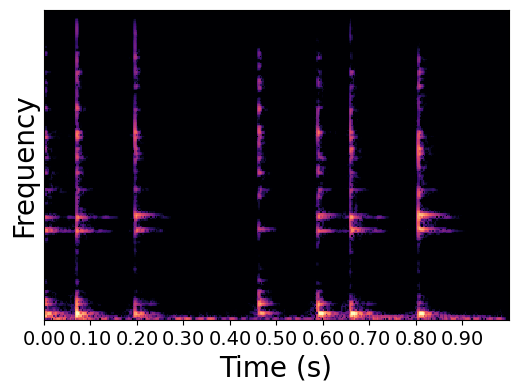

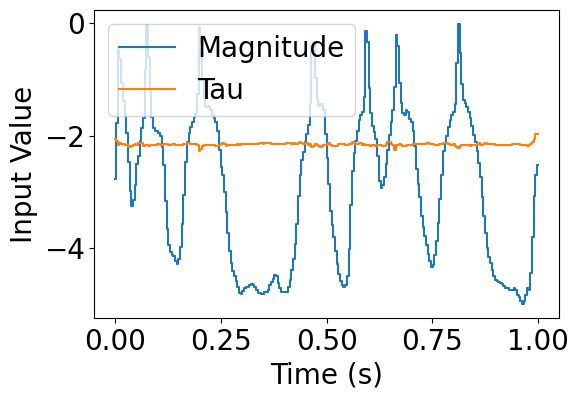

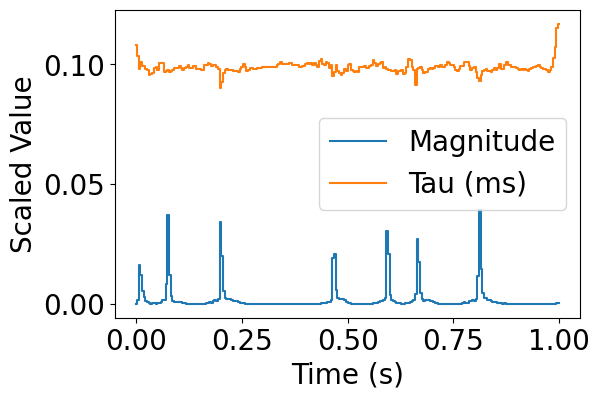

n_frames: 253 and n_intervals: 252
n_frames: 253 and n_intervals: 252


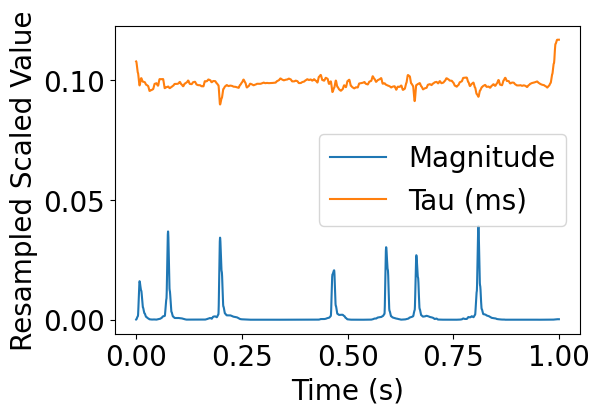

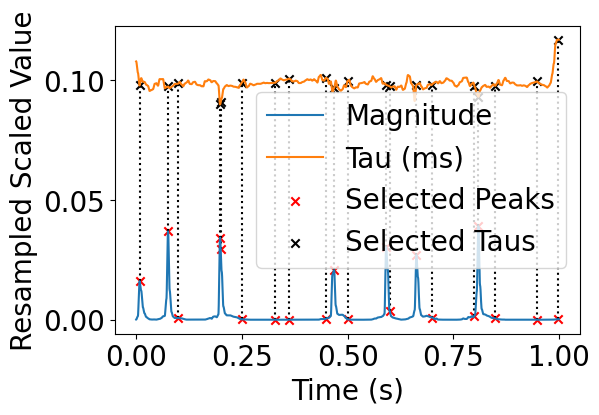

augmented indices: [[[[  310   350   390]
   [ 3285  3325  3365]
   [ 4370  4410  4450]
   [ 8710  8750  8790]
   [ 8780  8820  8860]
   [10985 11025 11065]
   [14485 14525 14565]
   [15885 15925 15965]
   [19804 19844 19884]
   [20610 20650 20690]
   [22010 22050 22090]
   [26035 26075 26115]
   [26420 26460 26500]
   [29185 29225 29265]
   [30830 30870 30910]
   [35239 35279 35319]
   [35660 35700 35740]
   [37445 37485 37525]
   [41785 41825 41865]
   [44011 44051 44091]]]]
b: 1, w: 1, h: 44100, c: 1


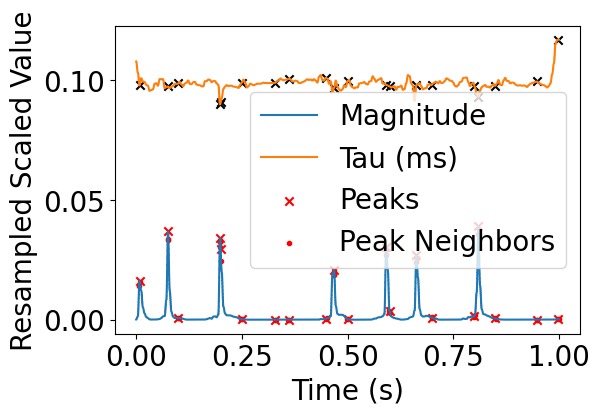

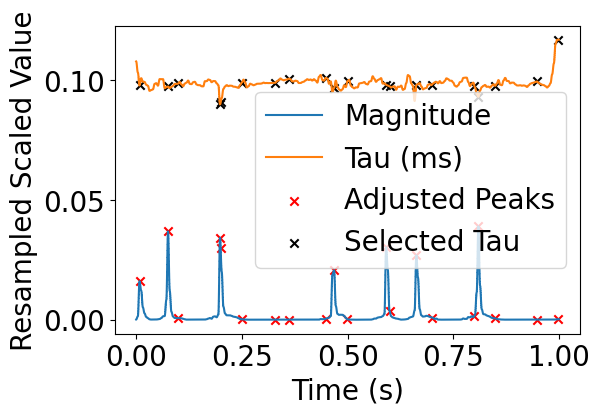

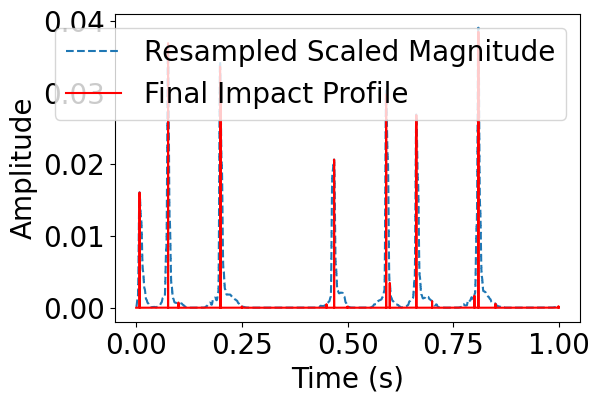

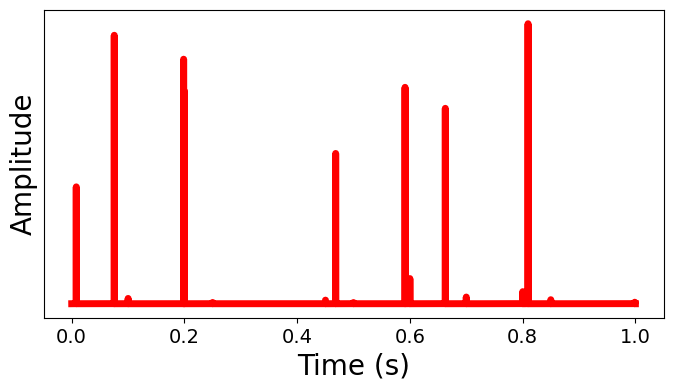

0.57123005
(257,)
(197, 345)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


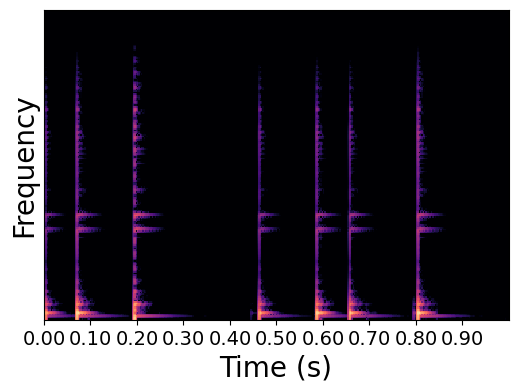

In [18]:
no_axis = True
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 20
plt.rcParams['font.size'] = font_size

save_title = audio_title.split('.')[0]

#output_dir = '/home/samuel/Downloads/impact_profile_noaxis'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/impact_profile_noaxis'
os.makedirs(output_dir, exist_ok=True)
plot_spec(prediction['audio'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
    plt.ylabel('Frequency')
    
fig.savefig(os.path.join(output_dir, save_title+'_original_spec.png'), bbox_inches='tight')
plt.show()

logit_length = np.squeeze(prediction['magnitudes']).shape[0]
t_logit = np.linspace(0, test_samples/train_sample_rate, logit_length)
plt.plot(t_logit, np.squeeze(prediction['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, np.squeeze(prediction['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Input Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_logits.png'), bbox_inches='tight')
plt.show()

plt.plot(t_logit, np.squeeze(prediction['impact']['controls']['magnitudes']), drawstyle='steps-mid')
plt.plot(t_logit, 1000 * np.squeeze(prediction['impact']['controls']['taus']), drawstyle='steps-mid')
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_scaled_logits.png'), bbox_inches='tight')
plt.show()

t = np.linspace(0, test_samples/train_sample_rate, test_samples)
magnitude_envelopes = ddsp.core.resample(prediction['impact']['controls']['magnitudes'], test_samples,
                                        method='window')
taus = ddsp.core.resample(prediction['impact']['controls']['taus'], test_samples,
                                        method='window')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.legend(('Magnitude', 'Tau (ms)'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_resampled_logits.png'), bbox_inches='tight')
plt.show()

window_size = int(train_sample_rate / 20)
magnitude_envelopes = tf.expand_dims(magnitude_envelopes, axis=1)
weight_distance = 40 #100
vals, inds = tf.nn.max_pool_with_argmax(magnitude_envelopes, window_size, window_size, 'SAME')
plt.plot(t, np.squeeze(magnitude_envelopes))
plt.plot(t, 1000 * np.squeeze(taus))
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.vlines(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], colors='black', linestyles='dotted')
plt.legend(('Magnitude', 'Tau (ms)', 'Selected Peaks', 'Selected Taus'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, save_title+'_peak_selection.png'), bbox_inches='tight')
fig.set_size_inches(fig_width, fig_height)
plt.show()

# Use a weighted average of magnitude to select peak time so that things can shift around
augmented_inds = tf.concat([inds - weight_distance, inds, inds + weight_distance], axis=-1)
print(f"augmented indices: {augmented_inds}")
b,w,h,c = magnitude_envelopes.get_shape().as_list()
print(f"b: {b}, w: {w}, h: {h}, c: {c}")
mags_pooled = tf.gather(tf.reshape(magnitude_envelopes, shape=[b*w*h*c]), augmented_inds)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(t[np.squeeze(inds)], np.squeeze(magnitude_envelopes)[np.squeeze(inds)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds-weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds-weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds+weight_distance)], np.squeeze(magnitude_envelopes)[np.squeeze(inds+weight_distance)], marker='.', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Peaks', 'Peak Neighbors'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_peak_adjustment.png'), bbox_inches='tight')
plt.show()

weighted_inds = tf.reduce_sum(tf.cast(augmented_inds, dtype=tf.float32) * mags_pooled, axis=-1) / tf.reduce_sum(mags_pooled, axis=-1)
peak_times = tf.cast(weighted_inds / train_sample_rate, dtype=tf.float32)
plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid')
plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
plt.legend(('Magnitude', 'Tau (ms)', 'Adjusted Peaks', 'Selected Tau'))
plt.xlabel('Time (s)')
plt.ylabel('Resampled Scaled Value')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_adjusted_peaks.png'), bbox_inches='tight')
plt.show()

plt.plot(t, np.squeeze(magnitude_envelopes), drawstyle='steps-mid', linestyle='dashed')
# plt.plot(t, 1000 * np.squeeze(taus), drawstyle='steps-mid')
# plt.scatter(peak_times, np.squeeze(magnitude_envelopes)[np.squeeze(weighted_inds).astype(np.int32)], marker='x', c='red')
# plt.scatter(t[np.squeeze(inds)], 1000* np.squeeze(taus)[np.squeeze(inds)], marker='x', c='black')
t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(('Resampled Scaled Magnitude','Final Impact Profile'))
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_impact_signal.png'), bbox_inches='tight')
plt.show()

t2 = np.linspace(0, test_samples/train_sample_rate, test_samples * 2)
plt.plot(t2, np.squeeze(prediction['impact']['signal']), c='red', linewidth=5)

plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
   
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_impact_signal_only.png'), bbox_inches='tight')
plt.show()

plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.ylabel('Frequency')
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_synth_spec.png'), bbox_inches='tight')
plt.show()

(176400,)


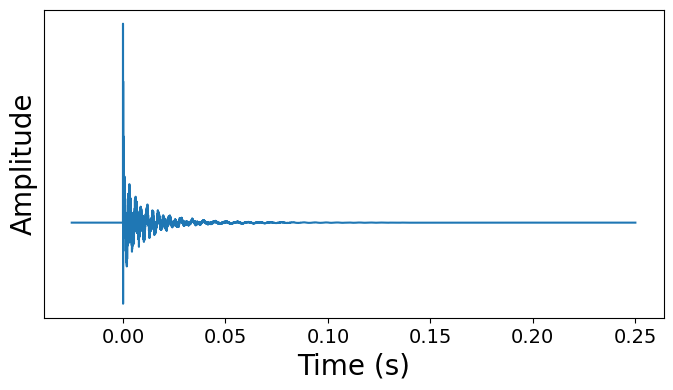

In [10]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
os.makedirs(output_dir, exist_ok=True)
begin_offset = int(train_sample_rate * 1.95)
cutoff = int(train_sample_rate * 2.5)

ir = np.squeeze(prediction['modal_fir']['signal'])
print(ir.shape)
ir = ir[begin_offset:cutoff]
t2 = (np.arange(0, ir.shape[0])  - (train_sample_rate * 2 - begin_offset)) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

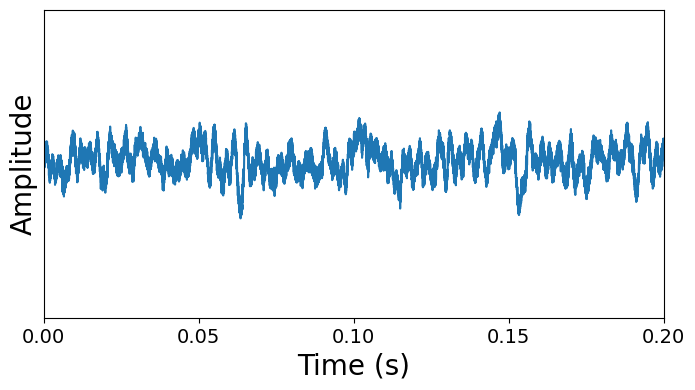

In [11]:
#output_dir = '/home/samuel/Downloads/filtered_noise'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/filtered_noise'
os.makedirs(output_dir, exist_ok=True)

noise = np.squeeze(prediction['filtered_noise']['signal'])
t2 = np.arange(0, 2 * train_sample_rate * example_secs) / (2 * train_sample_rate)
plt.plot(t2, noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.ylim((-0.0002, 0.0002))
plt.xlim((0, 0.2))
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_ir.png'), bbox_inches='tight')
plt.show()

(48882,)


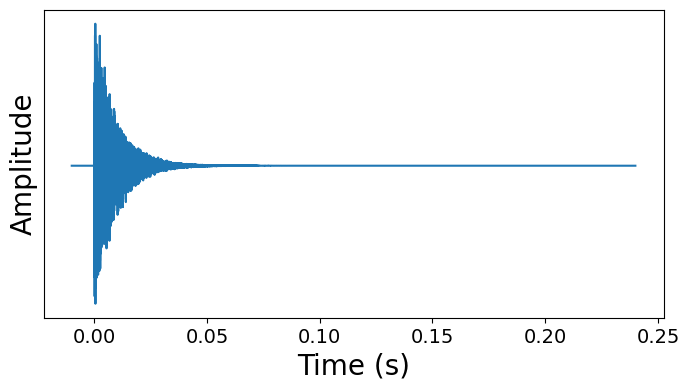

In [12]:
#output_dir = '/home/samuel/Downloads/modal_fir'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/modal_fir'
begin_offset = int(train_sample_rate * 0.02)
cutoff = int(train_sample_rate * 0.5)

ir = np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))
print(ir.shape)
ir = ir[:cutoff]
t2 = (np.arange(0, ir.shape[0])  - begin_offset) / (2 * train_sample_rate)
plt.plot(t2, ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+2, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_room_ir.png'), bbox_inches='tight')
plt.show()

0.57123005
(257,)
(197, 345)
[  0  20  40  60  80 100 120 140 160 180]
[    0.       1722.65625  3445.3125   5167.96875  6890.625    8613.28125
 10335.9375  12058.59375 13781.25    15503.90625]


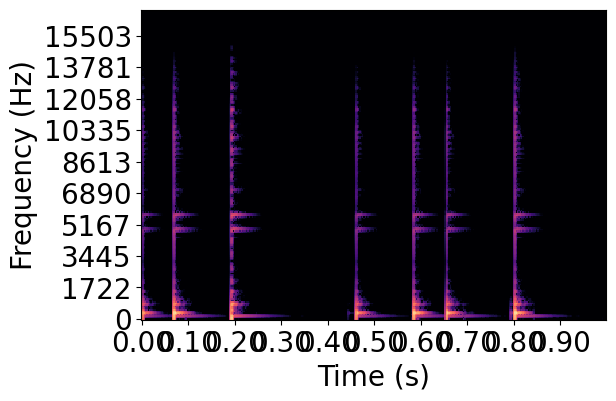

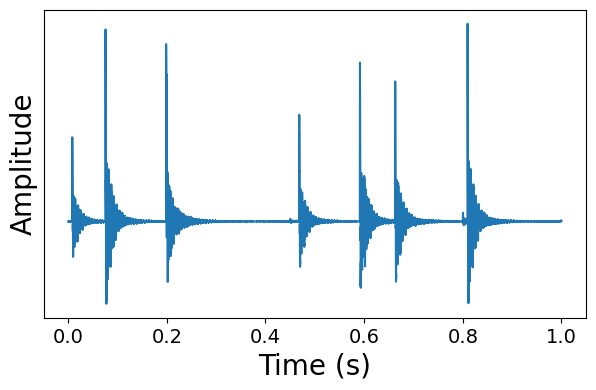

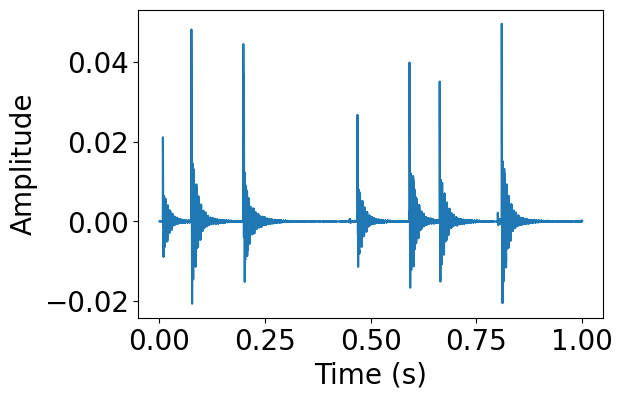

In [13]:
#output_dir = '/home/samuel/Downloads/final_audio'
output_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{vocoder_type}/final_audio'
os.makedirs(output_dir, exist_ok=True)

plot_spec(prediction['audio_synth'][:1, :train_sample_rate*2], 512)
fig = plt.gcf()
fig.savefig(os.path.join(output_dir, save_title+'_synth_spec.png'), bbox_inches='tight')
plt.show()
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width+1, fig_height)
if no_axis:
    ax = plt.gca()
    # ax.axes.yaxis.set_visible(False)
    ax.axes.yaxis.set_ticks([])
    plt.xticks(fontsize=font_size-6)
fig.savefig(os.path.join(output_dir, save_title+'_waveform.png'), bbox_inches='tight')
plt.show()
plt.rcParams.update({
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.2),
})
plt.plot(np.arange(0, train_sample_rate*example_secs) / train_sample_rate, np.squeeze(prediction['audio_synth'][:1,:]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)
fig.savefig(os.path.join(output_dir, save_title+'_waveform_translucent.png'), bbox_inches='tight')
plt.show()

In [14]:
# print(prediction['modal_fir']['controls']['frequencies'])
# if False:
modal_model = np.zeros((len(np.squeeze(prediction['modal_fir']['controls']['frequencies'])), 3), dtype=np.float32)
modal_model[:, 0] = np.squeeze(prediction['modal_fir']['controls']['frequencies'])
modal_model[:, 1] = np.squeeze(prediction['modal_fir']['controls']['gains'])
modal_model[:, 2] = np.squeeze(prediction['modal_fir']['controls']['dampings'])
np.save(os.path.join(output_dir, save_title+'_modal_model.npy'), modal_model)

In [ ]:
    for i in range(5):
    filename = 'XogoXRu8jvY-05-00%i0.wav'%i
    original_name = os.path.join('/data/datasets/asmr/tapping/valid/', filename)
    synth_name = os.path.join('examples/dubbing05-05-21/proposed', filename)
    audio = tf.io.read_file(original_name)
    decoded_audio, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
    decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio[:test_samples]), axis=0)
    test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
    prediction = model(next(iter(test_input)), training=False)
    audio_synth = prediction['audio_synth'][:1, :]
    scipy.io.wavfile.write(synth_name, int(audio_sample_rate), np.array(32767 * audio_synth[0, :] / np.max(np.abs(audio_synth))).astype(np.int16))

In [ ]:
time_begin = 1
example_secs = 1
gin.parse_config_file(ddsp.training.train_util.get_latest_operative_config(save_dir))
train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
model = ddsp.training.models.get_model()
model.restore(save_dir)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
prediction = model(next(iter(test_input)), training=False)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)

# 